<a href="https://colab.research.google.com/github/Wilkingc/Forecasting-Post-Fire-Debris-Flow/blob/main/Random_forest_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

original data:

https://pubs.usgs.gov/publication/ofr20161106

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_tree, XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.datasets import make_classification
from sklearn import preprocessing
import xgboost as xgb

import graphviz
from IPython.display import display
from sklearn import tree

import os
import requests

import zipfile
from io import BytesIO
from io import StringIO

## Reading in pickle file for cleaned un-balanced data set for 15

In [ ]:
df_original = pickle.load(open('/content/drive/MyDrive/proj7/data_15.p', 'rb'))

In [ ]:
df_original.shape

(1550, 13)

In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  1550 non-null   int64  
 1   UTM_Zone              1550 non-null   int64  
 2   Response              1550 non-null   int64  
 3   GaugeDist_m           1550 non-null   float64
 4   StormDur_H            1550 non-null   float64
 5   StormAccum_mm         1550 non-null   float64
 6   StormAvgI_mm/h        1550 non-null   float64
 7   Peak_I15_mm/h         1550 non-null   float64
 8   ContributingArea_km2  1550 non-null   float64
 9   PropHM23              1550 non-null   float64
 10  dNBR/1000             1550 non-null   float64
 11  KF                    1550 non-null   float64
 12  Acc015_mm             1550 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 157.5 KB


In [ ]:
df = df_original.drop(columns = ['Year', 'UTM_Zone'])
df.shape

(1550, 11)

In [ ]:
df['Response'].value_counts()

,count
Response,
0,1216
1,334


<Axes: >

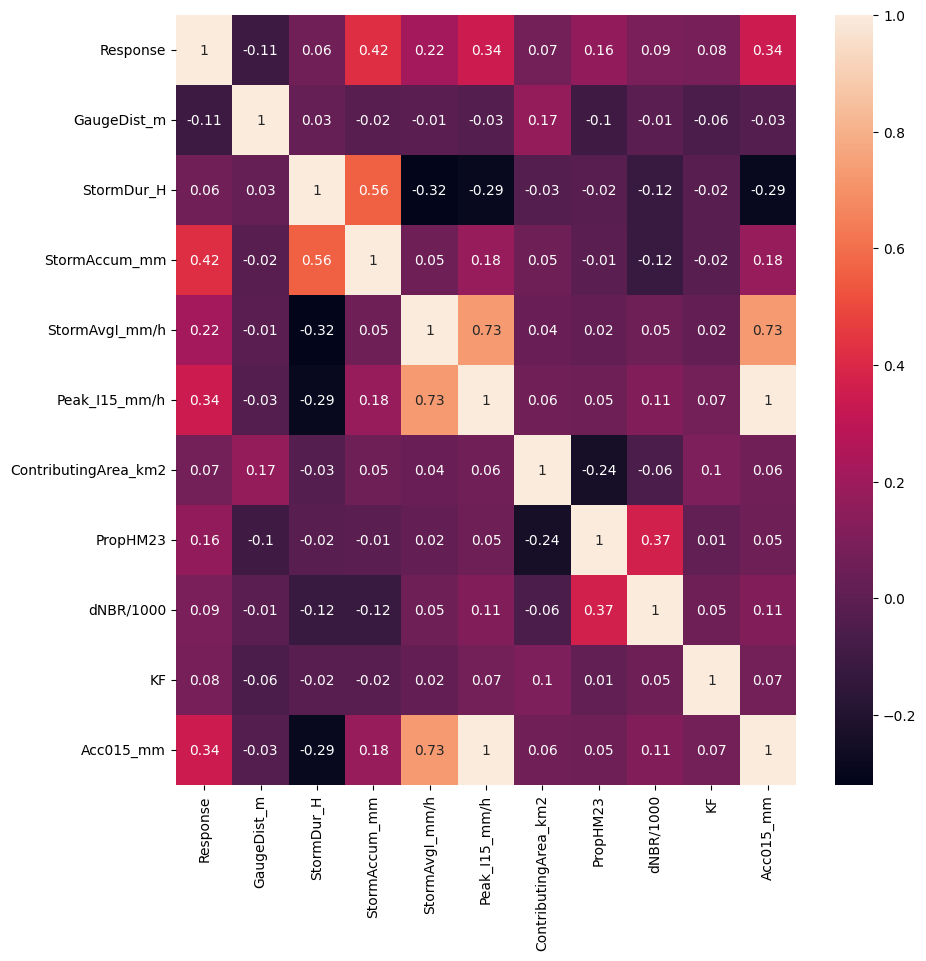

In [ ]:
plt.figure(figsize = (10,10))
correlation_matrix = df.corr().round(2)
sns.heatmap(data = correlation_matrix, annot = True)

odd that Peak_I15_mm/h is 100% corrolated with Acc015_mm

In [ ]:
df[['Peak_I15_mm/h','Acc015_mm']]

,Peak_I15_mm/h,Acc015_mm
0,3.2,0.80
1,3.2,0.80
2,3.2,0.80
3,1.6,0.40
4,1.6,0.40
...,...,...
1545,14.0,3.50
1546,63.0,15.75
1547,29.0,7.25
1548,25.0,6.25


In [ ]:
(df['Peak_I15_mm/h']/df['Acc015_mm']).value_counts()

,count
4.0,1550


## Decision Tree

In [ ]:
# 'Response' is the target
X = df.drop('Response', axis = 1)
y = df['Response']

**accuracy** = (TP + TN) / (TP + FP +TN + TP)

{good for when classes are balanced and not skewed}

**precision** = TP / (TP + FP)

{when we want to be very sure in our POSITIVE predictions}

**recall** = TP / (TP + FN)

{want to classify as many POSITIVES as possible}

**F1** = 2[(precision * recall)/(precision + recall)]

{when you want HIGH PRECISION & HIGH RECALL}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 13)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1085, 10), (1085,), (465, 10), (465,))

In [ ]:
model = DecisionTreeClassifier(random_state = 13)

In [ ]:
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=13)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 0, 0])

In [ ]:
y_pred.sum()

110

In [ ]:
pd.Series(y_pred).value_counts()

,count
0,355
1,110


In [ ]:
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)

Accuracy: 0.8774193548387097


In [ ]:
depth_range = range(1,21) # xv 20 times to get depth
accuracies = []
f1_scores = []
for depth in depth_range: # 20 *100 times
  numLoops = 100
  acc_dt = np.zeros(numLoops)
  f1s_dt = np.zeros(numLoops)

  for idx in range(0, numLoops): # 100 times
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    model = DecisionTreeClassifier(max_depth = depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc_dt[idx] = accuracy_score(y_test, y_pred)
    f1s_dt[idx] = f1_score(y_test, y_pred)
  accuracies.append(acc_dt.mean()) # could multiply mean by 100 to make percent for graph
  f1_scores.append(f1s_dt.mean())  # but not going to do that
  print(f'Accuracy: {acc_dt.mean()}')
  print(f'F1: {f1s_dt.mean()}')
# picked depth, creating 20 models, accuracy calculated for each, then mean calculated

Accuracy: 0.7778064516129034
F1: 0.3165754896463397
Accuracy: 0.8182795698924731
F1: 0.3523192452440598
Accuracy: 0.8197419354838708
F1: 0.5018810421412754
Accuracy: 0.8337849462365593
F1: 0.5741547175167262
Accuracy: 0.8435483870967743
F1: 0.626601206896099
Accuracy: 0.8501505376344085
F1: 0.6399026356090017
Accuracy: 0.8538494623655913
F1: 0.6543670459266135
Accuracy: 0.8621505376344086
F1: 0.6779966196571853
Accuracy: 0.8643655913978493
F1: 0.6790524121684649
Accuracy: 0.860215053763441
F1: 0.675808686087868
Accuracy: 0.8611612903225806
F1: 0.6767900060021753
Accuracy: 0.8592043010752688
F1: 0.6692070134083142
Accuracy: 0.8598494623655913
F1: 0.6723017525826791
Accuracy: 0.8622580645161291
F1: 0.6761024111007046
Accuracy: 0.8605591397849461
F1: 0.6785344612190641
Accuracy: 0.8607096774193549
F1: 0.6762987485474069
Accuracy: 0.8649032258064514
F1: 0.6815863612276548
Accuracy: 0.8619139784946236
F1: 0.678845855319273
Accuracy: 0.8646236559139784
F1: 0.6806332566520529
Accuracy: 0.8602

### line graph

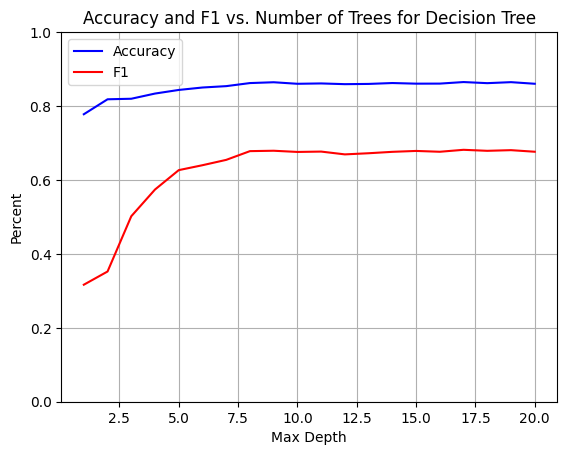

In [ ]:
plt.figure()
plt.plot(depth_range, accuracies, color = 'b', label = 'Accuracy')
plt.plot(depth_range, f1_scores, color = 'r', label = 'F1')
plt.ylabel('Percent')
plt.legend()
plt.xlabel('Max Depth')
plt.grid()
plt.ylim(0,1)
plt.title('Accuracy and F1 vs. Number of Trees for Decision Tree')
plt.savefig('dt_15_acc_f1_line_graph.png')
plt.show()

In [ ]:
# cross validation
numLoops = 100

acc_dt = np.zeros(numLoops)
f1s_dt = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = DecisionTreeClassifier(max_depth = 8)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_dt[idx] = accuracy_score(y_test, y_pred)
  f1s_dt[idx] = f1_score(y_test, y_pred)
print(f'Accuracy: {acc_dt.mean()}')
print(f'F1: {f1s_dt.mean()}')

Accuracy: 0.8607956989247312
F1: 0.6738410295609579


In [ ]:
plot_dt = pd.DataFrame(zip(acc_dt, f1s_dt))
plot_dt

,0,1
0,0.853763,0.676190
1,0.847312,0.653659
2,0.879570,0.702128
3,0.873118,0.646707
4,0.868817,0.699507
...,...,...
95,0.838710,0.571429
96,0.827957,0.607843
97,0.849462,0.666667
98,0.866667,0.651685


### histogram

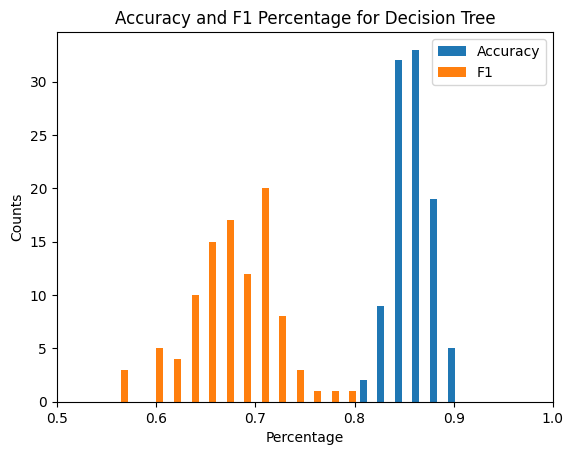

In [ ]:
plt.hist(plot_dt, bins = 20)
plt.legend(['Accuracy', 'F1'])
plt.ylabel('Counts')
plt.xlabel('Percentage')
plt.title('Accuracy and F1 Percentage for Decision Tree')
plt.xlim(0.5,1)
plt.savefig('dt_15_acc_f1_hist_graph.png')
plt.show()

### trees

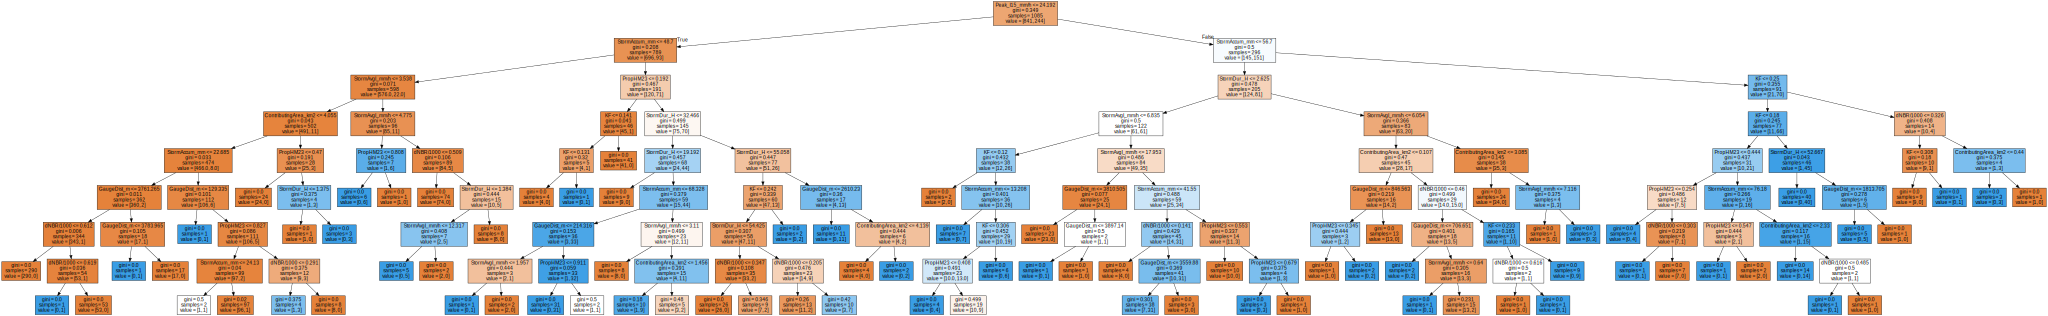

In [ ]:
display(
  graphviz.Source(
    tree.export_graphviz(
      model,
      feature_names = X.columns,
      filled = True,
    )
  )
)
# 100th DT out of all the ones from model (last one)

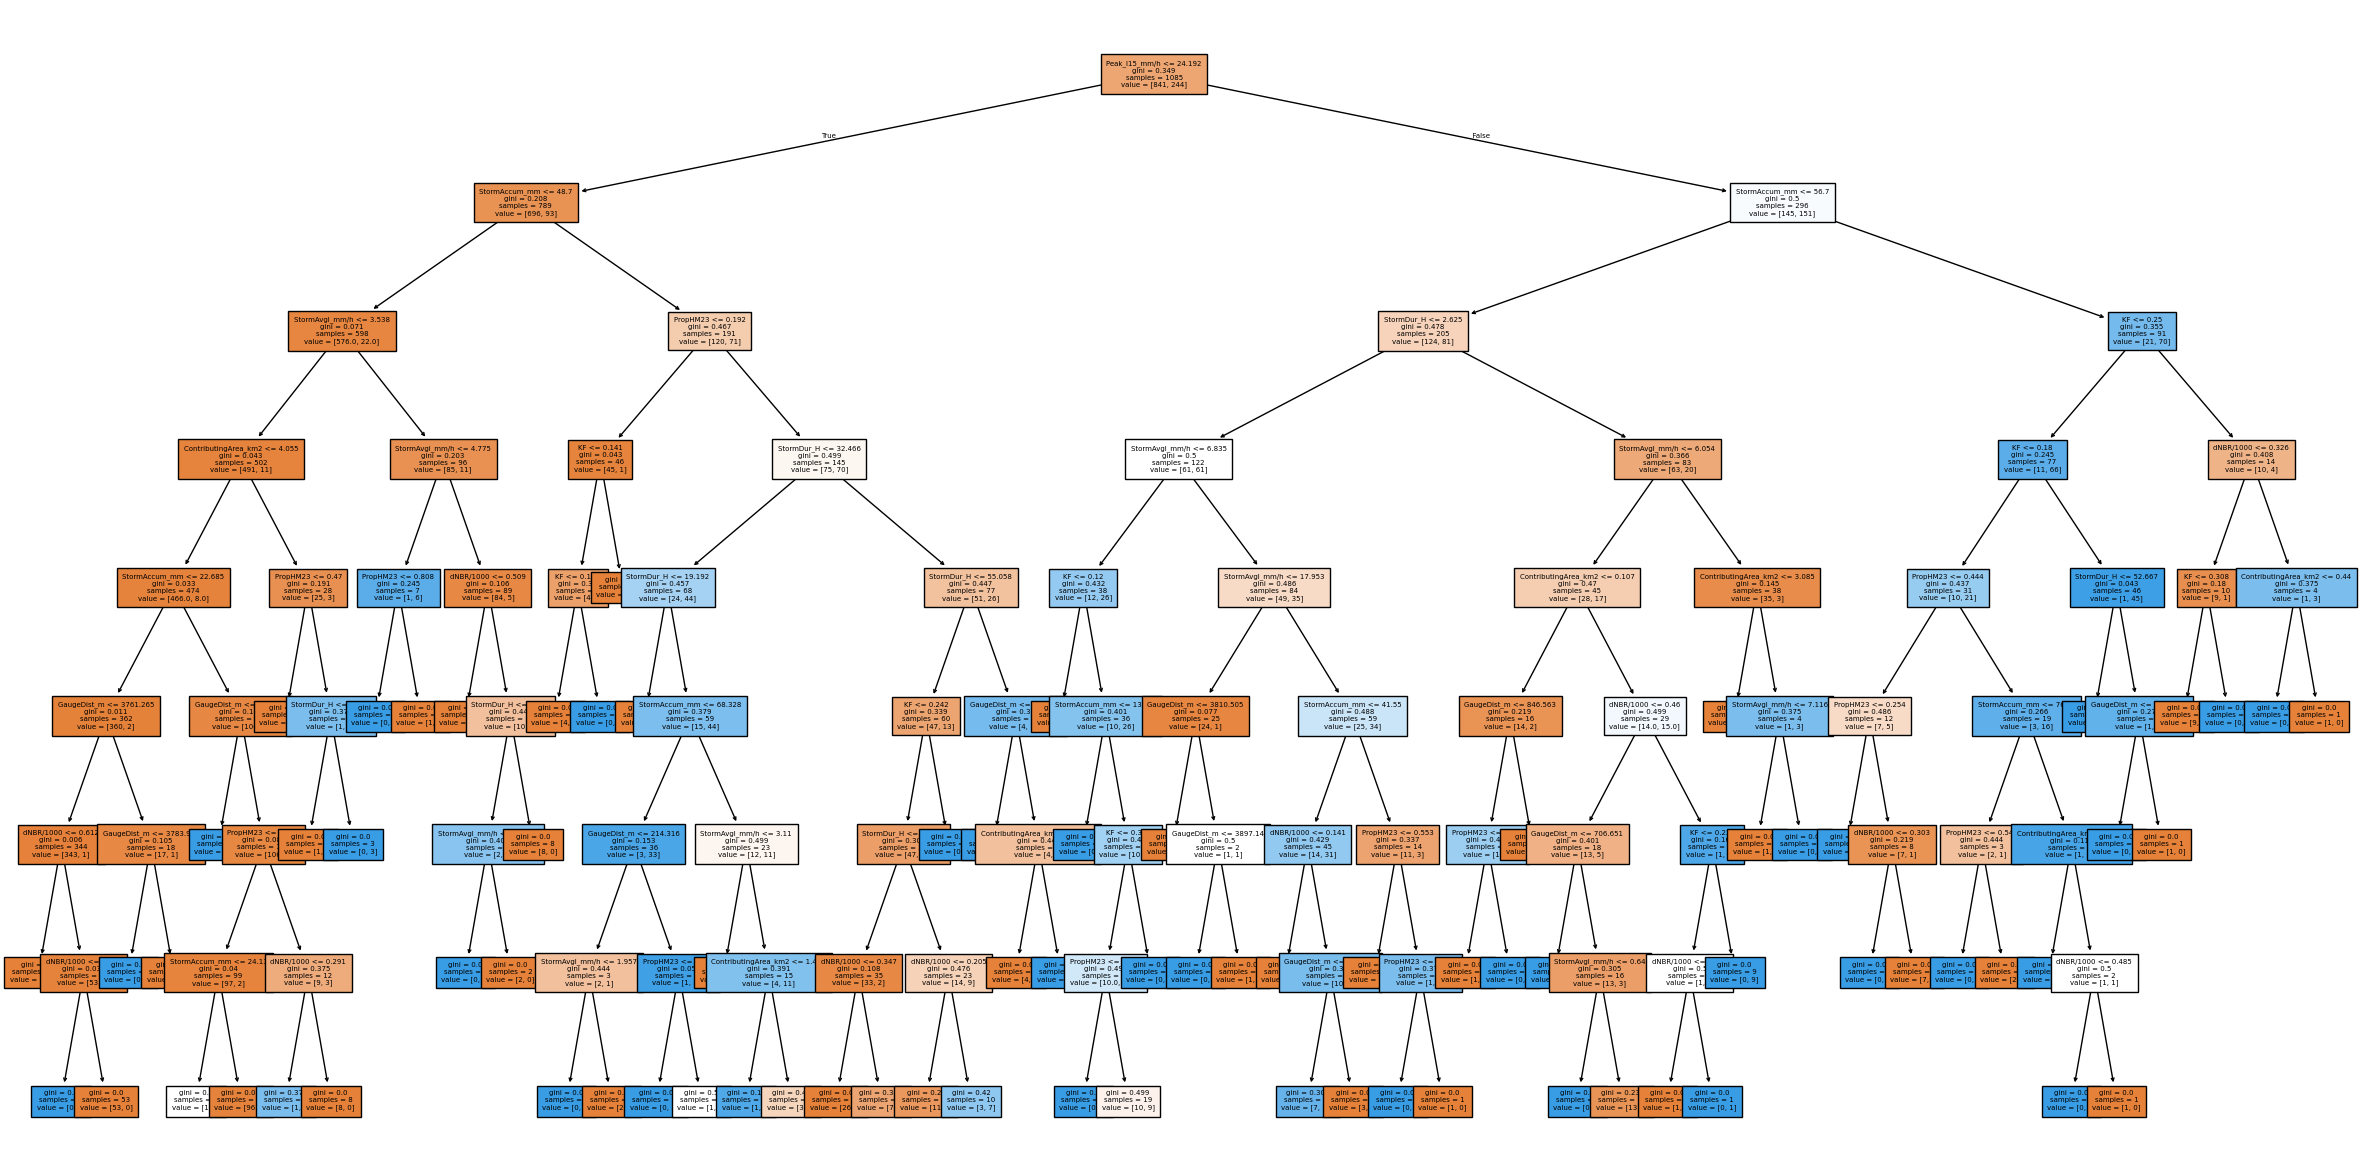

In [ ]:
# skinny tree
plt.figure(figsize = (30,15))
# plot is as a .svg -- at the end
tree_plot = tree.plot_tree(
    model,
    feature_names = X.columns,
    filled = True,
    fontsize = 5,
)
plt.savefig('dt_15_tree.png')

## Random Forest

In [ ]:
X = df.drop('Response', axis = 1)
y = df['Response']

In [ ]:
# no max_depth inputted for model
numLoops = 100
acc_rf = np.zeros(numLoops)
f1s_rf = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = RandomForestClassifier()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_rf[idx] = accuracy_score(y_test, y_pred)
  f1s_rf[idx] = f1_score(y_test, y_pred)
print(f'Accuracy: {acc_rf.mean()}')
print(f'F1: {f1s_rf.mean()}')

Accuracy: 0.8961935483870969
F1: 0.7469564603671478


In [ ]:
numLoops = 100
acc_rf = np.zeros(numLoops)
f1s_rf = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = RandomForestClassifier(max_depth = 8)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_rf[idx] = accuracy_score(y_test, y_pred)
  f1s_rf[idx] = f1_score(y_test, y_pred)
print(f'Accuracy: {acc_rf.mean()}')
print(f'F1: {f1s_rf.mean()}')

Accuracy: 0.8896129032258063
F1: 0.7250424111824348


In [ ]:
# using accuracy as metric, not f1
# choosing number of trees
# cross validation
num_trees = range(10,100,10)
cv_loops = 100
acc_rf = np.zeros(len(num_trees))
f1s_rf = np.zeros(len(num_trees))

for n, trees in enumerate(num_trees): # 9 diff sizeof f
  acc = np.zeros(cv_loops)
  f1 = np.zeros(cv_loops)
  np.random.seed(13)
  for i in range(cv_loops): #100 xv
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    rfModel = RandomForestClassifier(n_estimators = trees)
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    acc[i] = accuracy_score(y_test, y_pred_rf)
    f1[i] = f1_score(y_test, y_pred_rf)
  print(trees, 'trees finished')
  acc_rf[n] = acc.mean()
  f1s_rf[n] = f1.mean()

10 trees finished
20 trees finished
30 trees finished
40 trees finished
50 trees finished
60 trees finished
70 trees finished
80 trees finished
90 trees finished


### line graph

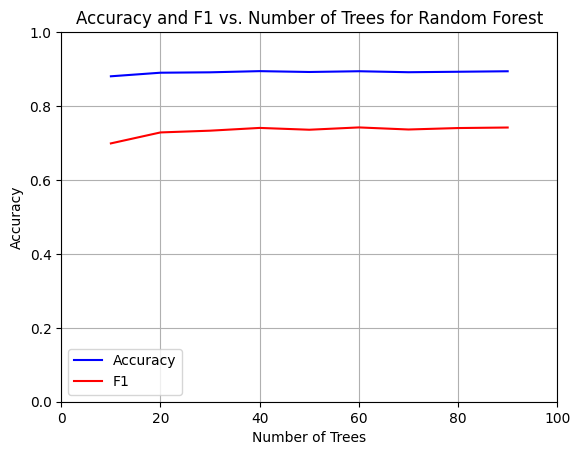

In [ ]:
plt.figure()
plt.plot(num_trees, acc_rf, color = 'b', label = 'Accuracy')
plt.plot(num_trees, f1s_rf, color = 'r', label = 'F1')

# plt.plot(num_trees, acc_rf, f1s_rf_1)
plt.title('Accuracy and F1 vs. Number of Trees for Random Forest')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.xlim(0,100)
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.savefig('rf_15_acc_f1_line_graph.png')
plt.show()

In [ ]:
print(f'Accuracy with 10 trees: {acc_rf[0]}')

Accuracy with 10 trees: 0.8804946236559139


In [ ]:
len(rfModel.estimators_)

90

In [ ]:
numLoops = 100
acc_rf = np.zeros(numLoops)
f1s_rf = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = RandomForestClassifier(max_depth = 10)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc_rf[idx] = accuracy_score(y_test, y_pred)
  f1s_rf[idx] = f1_score(y_test, y_pred)
print(f'Accuracy: {acc_rf.mean()}')
print(f'F1: {f1s_rf.mean()}')

Accuracy: 0.8936989247311828
F1: 0.7416156024925162


### tree

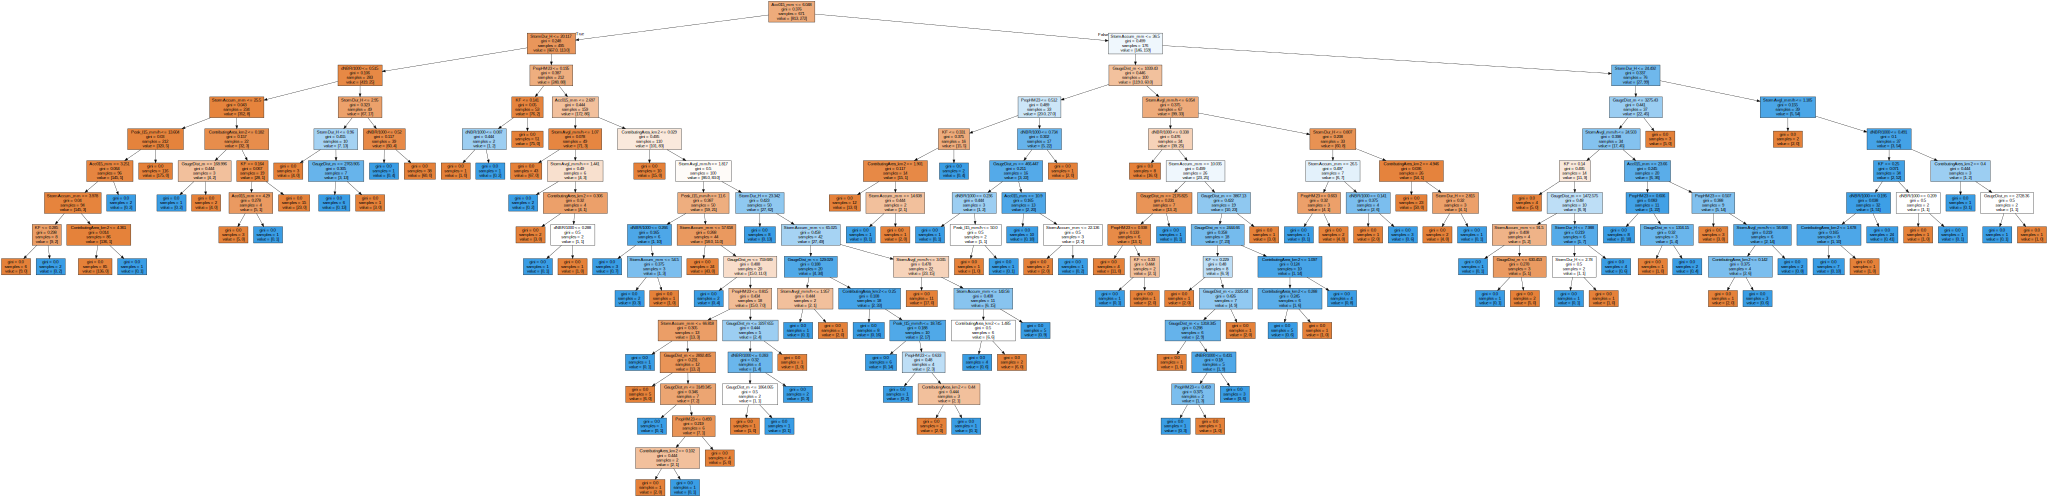

In [ ]:
display(
  graphviz.Source(
    tree.export_graphviz(
      rfModel.estimators_[89],
      feature_names = X.columns,
      filled = True,
    )
  )
)

### histogram

In [ ]:
plot_rf = pd.DataFrame(zip(acc_rf, f1s_rf))
plot_rf

,0,1
0,0.875269,0.666667
1,0.892473,0.752475
2,0.916129,0.795812
3,0.907527,0.770053
4,0.879570,0.698925
...,...,...
95,0.905376,0.755556
96,0.888172,0.747573
97,0.894624,0.732240
98,0.894624,0.746114


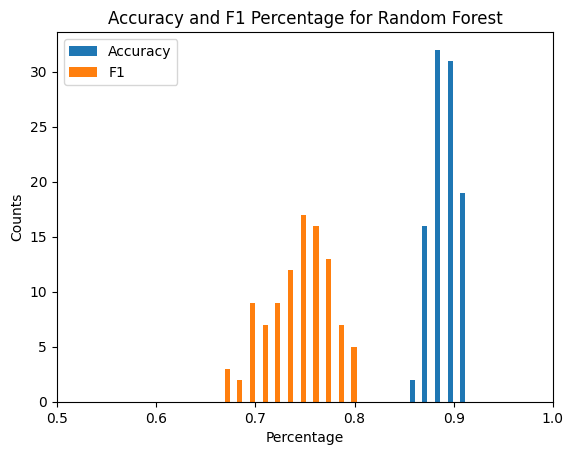

In [ ]:
plt.hist(plot_rf, bins = 20)
plt.legend(['Accuracy', 'F1'])
plt.xlim(0.5,1)
plt.ylabel('Counts')
plt.xlabel('Percentage')
plt.title('Accuracy and F1 Percentage for Random Forest')
plt.savefig('rf_15_acc_f1_hist_graph.png')
plt.show() # same as d.t.
# save each graph, save then plot

### feature importance

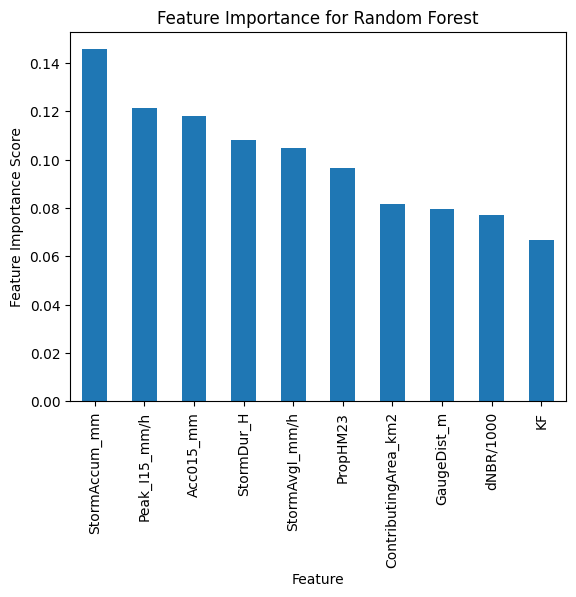

In [ ]:
# importance predictors
importances = rfModel.feature_importances_
forest_importances = pd.Series(importances, index = X.columns)
plt.figure()
forest_importances.sort_values(ascending = False).plot.bar()
plt.title('Feature Importance for Random Forest')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')
plt.savefig('rf_15_FI.png')
plt.show()

In [ ]:
(forest_importances.sort_values(ascending = False) * 100).cumsum()

,0
StormAccum_mm,14.563279
Peak_I15_mm/h,26.691789
Acc015_mm,38.497046
StormDur_H,49.304488
StormAvgI_mm/h,59.797612
PropHM23,69.458143
ContributingArea_km2,77.609246
GaugeDist_m,85.588768
dNBR/1000,93.301858
KF,100.000000


## XGBoost

In [ ]:
X = df.drop('Response', axis = 1)
y = df['Response']

In [ ]:
numLoops = 100
acc_xgb = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  xgbr = xgb.XGBClassifier(objective = 'binary:logistic', verbosity = 0)
  xgbr.fit(X_train, y_train)
  y_pred_xgb = xgbr.predict(X_test)
  acc_xgb[idx] = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {acc_xgb.mean()}')

Accuracy: 0.8912688172043011


In [ ]:
# specifying parameters we want to try and their ranges
param_test = {
    'max_depth' : [3, 4, 5, 6, 7],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4],
    'n_estimators' : [20, 40, 60, 80, 100, 120, 140],
}
# grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic'),
    param_grid = param_test,
    scoring = 'accuracy',
    cv = 5,
)
# fit to the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 13)
model = gsearch.fit(X_train, y_train)
# show results
print(model.best_params_)

{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
params = model.best_params_
params

{'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 100}

In [ ]:
# fitting XGBoost model with the best parameters
# cross validation
numLoops = 100
acc_xgb = np.zeros(numLoops)
f1s_xgb = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  xgbc = xgb.XGBClassifier(
      objective = 'binary:logistic',
      verbosity = 0,
      **params,
  )
  xgbc.fit(X_train, y_train)
  y_pred_xgb = xgbc.predict(X_test)
  acc_xgb[idx] = accuracy_score(y_test, y_pred_xgb)
  f1s_xgb[idx] = f1_score(y_test, y_pred_xgb)
print(f'Accuracy: {acc_xgb.mean()}')
print(f'F1: {f1s_xgb.mean()}')

Accuracy: 0.8878924731182795
F1: 0.7264997069781338


### histogram

In [ ]:
plot_xgb = pd.DataFrame(zip(acc_xgb, f1s_xgb))
plot_xgb

,0,1
0,0.903226,0.771574
1,0.881720,0.712042
2,0.883871,0.712766
3,0.888172,0.745098
4,0.896774,0.703704
...,...,...
95,0.858065,0.666667
96,0.877419,0.701571
97,0.892473,0.766355
98,0.898925,0.748663


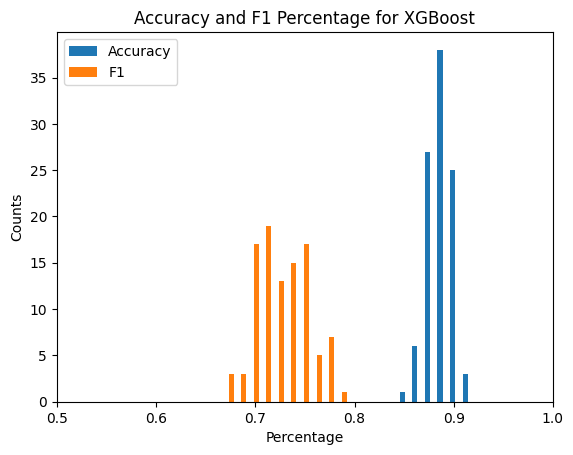

In [ ]:
plt.hist(plot_xgb, bins = 20)
plt.legend(['Accuracy', 'F1'])
plt.xlim(0.5,1)
plt.ylabel('Counts')
plt.xlabel('Percentage')
plt.title('Accuracy and F1 Percentage for XGBoost')
plt.savefig('xgb_15_acc_f1_hist_graph.png')
plt.show()

### feature importance

<ipython-input-49-45a113996c48>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


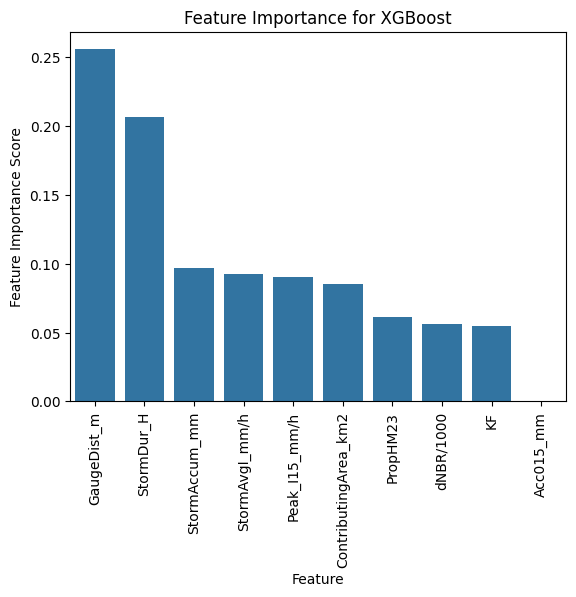

In [ ]:
# feature importance
feat_import = pd.Series(xgbc.feature_importances_, index = X.columns)
plt.figure()
ax = sns.barplot(x = feat_import.index, y = feat_import.sort_values(ascending = False).values)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xlabel('Feature')
plt.title('Feature Importance for XGBoost')
plt.ylabel('Feature Importance Score')
plt.savefig('xgb_15_FI.png')
plt.show();

In [ ]:
(feat_import.sort_values(ascending = False) * 100).cumsum()

,0
Peak_I15_mm/h,25.574753
StormAccum_mm,46.240673
PropHM23,55.914276
KF,65.211937
StormDur_H,74.252953
StormAvgI_mm/h,82.780403
ContributingArea_km2,88.899467
GaugeDist_m,94.538177
dNBR/1000,100.000008
Acc015_mm,100.000008
